Notebook de exploração e contrução dos modelos para o TCC.

Nome: Artur Tiburski Vaz Costa

Título: Aplicação e comparação dos modelos XGBoost e LightGBM na previsão de demanda de bebidas alcoólicas em região do Estado de Iowa, EUA

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from datetime import datetime
import holidays
import xgboost as xgb
import lightgbm
from datetime import timedelta, date
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import skew, kurtosis
import warnings
import pickle

warnings.filterwarnings('ignore')

Puxando os dados extraídos em .csv do site https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/about_data e também a base de de-para de County para Região dos Estado de Iowa, (em .csv também). Ainda, removemos eventuais erros de dados nos quais o County da venda não aparece (está null).

Juntamos as bases usando County como chave de forma a trazer para a base de faturamentos a Região de cada venda. Eventuais venda com valores negativos são removidos (podem estar associados a estornos).

In [194]:
df = pd.read_csv("Iowa_Liquor_Sales.csv")
regions = pd.read_csv("counties_iowa_regions.csv")
df = df[~df["County"].isnull()]
df = pd.merge(df, regions[['County', 'Region']], left_on='County', right_on='County', how='left')
df = df.loc[df["Volume Sold (Liters)"] > 0]

In [3]:
df.describe()

,Volume Sold (Liters)
count,9.968680e+06
mean,9.246712e+00
std,4.099762e+01
min,2.000000e-02
25%,1.500000e+00
50%,4.500000e+00
75%,1.050000e+01
max,1.320000e+04


Primeiramente agrupamos os dados (fazendo o somatório do Volume) de faturamento nas chaves Região e Data, onde:

"Region": Região do Estado;

"Date": Data de venda;

"Volume Sold (Liters)": Volume de bebida alcoólica vendida em litros (L).

In [195]:
df_g = df.groupby(['Region', 'Date']).agg({'Volume Sold (Liters)':'sum'})

df_g.reset_index(inplace=True)

Convertemos a coluna "Date" para formato de data

In [196]:
df_g['Date'] = pd.to_datetime(df_g['Date'])
df_g.sort_values("Date", ascending=True)["Date"]

0      2020-01-02
2122   2020-01-02
3122   2020-01-02
4035   2020-01-02
1092   2020-01-02
          ...    
2988   2023-10-31
1988   2023-10-31
3912   2023-10-31
944    2023-10-31
4942   2023-10-31
Name: Date, Length: 5079, dtype: datetime64[ns]

Primeiras etapas de engenharia de atributos com a criação de features de caracterírsticas temporais associadas, por exemplo, às características do período de cada data.

Juntamente, é realizado um novo agrupamento dos dados, agora com a granularidade temporal de Semana.

In [197]:
def is_iowa_holiday(input_dates):

    # função que aponta de uma certa data é feriado no estado de Iowa
    # e/ou nos Estados Unidos

    us_holidays = holidays.US(years=[2020, 2021, 2022, 2023])
    iowa_holidays = holidays.US(years=[2020, 2021, 2022, 2023], observed=True, state='IA')
    
    # Se é feriado, coluna retorna 1. Se não é feriado, retorna 0.
    return input_dates.apply(lambda x: 1 if x in us_holidays or x in iowa_holidays else 0)


df_g['Date'] = pd.to_datetime(df_g['Date'])
df_g['Year-Week'] = df_g['Date'].apply(lambda x: f"{x.isocalendar()[0]}-{x.isocalendar()[1]:02d}")
df_g['Week_of_year'] = df_g['Date'].dt.isocalendar().week
df_g['IsHoliday'] = is_iowa_holiday(df_g['Date'])
df_g['Is_quarter_end'] = df_g['Date'].apply(lambda x: 1 if x.is_quarter_end else 0)
df_g['Is_quarter_start'] = df_g['Date'].apply(lambda x: 1 if x.is_quarter_start else 0)
df_g['Is_month_start'] = df_g['Date'].apply(lambda x: 1 if x.is_month_start else 0)
df_g['Is_month_end'] = df_g['Date'].apply(lambda x: 1 if x.is_month_end else 0)

# novo agrupamento dos dados agora utilizando a granularidade temporal de Semanas.
# para cada semana, julgamos os dias nelas existentes e suas características
# defindas nos comandos acima.

grouped_data = df_g.groupby(['Region', 'Year-Week']).agg({'Week_of_year': 'max',
                                                        'IsHoliday': 'max',
                                                        'Is_quarter_end': 'max',
                                                        'Is_quarter_start': 'max',
                                                        'Is_month_start': 'max',
                                                        'Is_month_end': 'max',
                                                        'Volume Sold (Liters)':'sum'}).reset_index()


# Criação de coluna apontando o primeiro dia da semana de forma
# a associar a cada semana características temporais das mesmas
# como número da semana no mês e no ano e entre outras.

grouped_data['date_ref_week'] = pd.to_datetime(grouped_data['Year-Week'] + '-1', format="%Y-%W-%w")

grouped_data['Month'] = grouped_data['date_ref_week'].dt.month
grouped_data['Week_of_month'] = (grouped_data['date_ref_week'].dt.day - 1) // 7 + 1
grouped_data['Quarter'] = grouped_data['date_ref_week'].dt.quarter
grouped_data['Days_in_month'] = grouped_data['date_ref_week'].dt.days_in_month

In [77]:
grouped_data

,Region,Year-Week,Week_of_year,IsHoliday,Is_quarter_end,Is_quarter_start,Is_month_start,Is_month_end,Volume Sold (Liters),date_ref_week,Month,Week_of_month,Quarter,Days_in_month
0,Central,2020-01,1,0,0,0,0,0,54567.26,2020-01-06,1,1,1,31
1,Central,2020-02,2,0,0,0,0,0,119661.86,2020-01-13,1,2,1,31
2,Central,2020-03,3,0,0,0,0,0,95073.59,2020-01-20,1,3,1,31
3,Central,2020-04,4,1,0,0,0,0,123237.39,2020-01-27,1,4,1,31
4,Central,2020-05,5,0,0,0,0,1,113500.89,2020-02-03,2,1,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,Southeast,2023-40,40,0,0,0,0,0,164658.05,2023-10-02,10,1,4,31
1001,Southeast,2023-41,41,1,0,0,0,0,171441.67,2023-10-09,10,2,4,31
1002,Southeast,2023-42,42,0,0,0,0,0,128334.81,2023-10-16,10,3,4,31
1003,Southeast,2023-43,43,0,0,0,0,0,141654.37,2023-10-23,10,4,4,31


Vamos trabalhar com a região Northwest (Noroeste). abaixo, filtramos ela no dataset.

In [198]:
df_northwest = grouped_data.loc[grouped_data["Region"]=="Northwest"]

### Ínicio da exploração dos dados no escopo da região de interesse Noroeste.

Primeiramente, vamos analisar a distribuição temporal dos Volumes de Venda (L) original na região Noroeste. Ainda, estamos definindo uma função abaixo a qual auxiliará, posteriormente, na construção de relatórios estatísticos para a distribuição do Volume Vendido (L).

In [199]:
def stats_report(df, cond="geral"):

    '''
    função para auxiliar na geração de relatório estatístico
    sobre a distribuição dos dados de Volume (L)
    '''
    
    if cond == "geral":
    
        region_stats = df.groupby(['Region']).agg(
                                                Soma=('Volume Sold (Liters)', np.sum),
                                                Media=('Volume Sold (Liters)', np.mean),
                                                Third_Q=('Volume Sold (Liters)', lambda x: np.percentile(x, 75)),
                                                First_Q=('Volume Sold (Liters)', lambda x: np.percentile(x, 25)),
                                                Mediana=('Volume Sold (Liters)', np.median),
                                                Std=('Volume Sold (Liters)', np.std),
                                                Max=('Volume Sold (Liters)', np.max),
                                                Min=('Volume Sold (Liters)', np.min)
                                                ).reset_index()
        
        region_stats['Skewness'] = df.groupby(['Region'])['Volume Sold (Liters)'].apply(skew).reset_index(drop=True)
        region_stats['Kurtosis'] = df.groupby(['Region'])['Volume Sold (Liters)'].apply(kurtosis).reset_index(drop=True)
    
    elif cond == "set":

        df_set = df.rename(columns={"Year-Week": 'Set'})
        df_set["Set"] = df_set.apply(lambda x: 'Test' if x.Set[:6] in ('2023-2', '2023-3', '2023-4') else 'Train', axis=1)
        
        region_stats = df_set.groupby(['Region', 'Set']).agg(
                                                        Soma=('Volume Sold (Liters)', np.sum),
                                                        Media=('Volume Sold (Liters)', np.mean),
                                                        Third_Q=('Volume Sold (Liters)', lambda x: np.percentile(x, 75)),
                                                        First_Q=('Volume Sold (Liters)', lambda x: np.percentile(x, 25)),
                                                        Mediana=('Volume Sold (Liters)', np.median),
                                                        Std=('Volume Sold (Liters)', np.std),
                                                        Max=('Volume Sold (Liters)', np.max),
                                                        Min=('Volume Sold (Liters)', np.min)
                                                        ).reset_index()
        
        region_stats['Skewness'] = df_set.groupby(['Region', 'Set'])['Volume Sold (Liters)'].apply(skew).reset_index(drop=True)
        region_stats['Kurtosis'] = df_set.groupby(['Region', 'Set'])['Volume Sold (Liters)'].apply(kurtosis).reset_index(drop=True)

    
    region_stats['CV'] = region_stats['Std'] / region_stats['Media']
    region_stats['IQR'] = region_stats['Third_Q'] - region_stats['First_Q']
    region_stats['Max - Min'] = region_stats['Max'] - region_stats['Min']

    return region_stats
 

Abaixo, podemos ver que a distribuição semanal de vendas na região Noroeste possui algumas semanas com volumes bastante distintos, podendo ser considerados como potenciais outliers em comparação ao comportamento geral de vendas. Na modelagem não apenas de séries temporais mas também de problemas de regressão em geral, é importante tratar (através de simples remoção, por exemplo) estes casos de forma a não gerar um treinamento cujos exemplos podem conter dados distintos do comportamento generalizável.  

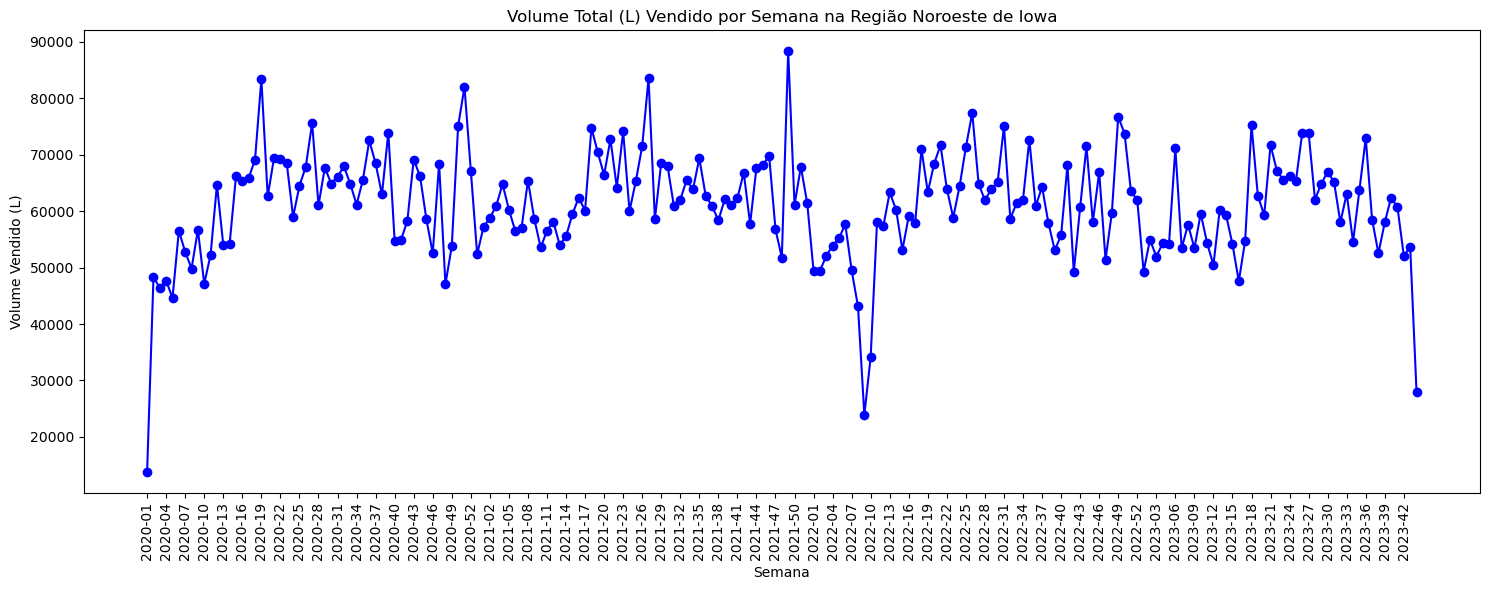

In [200]:
plt.figure(figsize=(15, 6))
plt.plot(df_northwest['Year-Week'], df_northwest['Volume Sold (Liters)'], marker='o', linestyle='-', color='b')
plt.xlabel('Semana')
plt.ylabel('Volume Vendido (L)')
plt.title('Volume Total (L) Vendido por Semana na Região Noroeste de Iowa')

tick_labels = df_northwest['Year-Week'][::3]
plt.xticks(tick_labels, rotation=90)

plt.tight_layout()
plt.show()

Abaixo, faremos o tratamento dos outliers através da técnica de detecção Isolation Forest utilizando seus hiperparâmetros padrão conforme documentação. Assim, os casos (semanas) detectadas como potenciais outliers serão removidos da série.

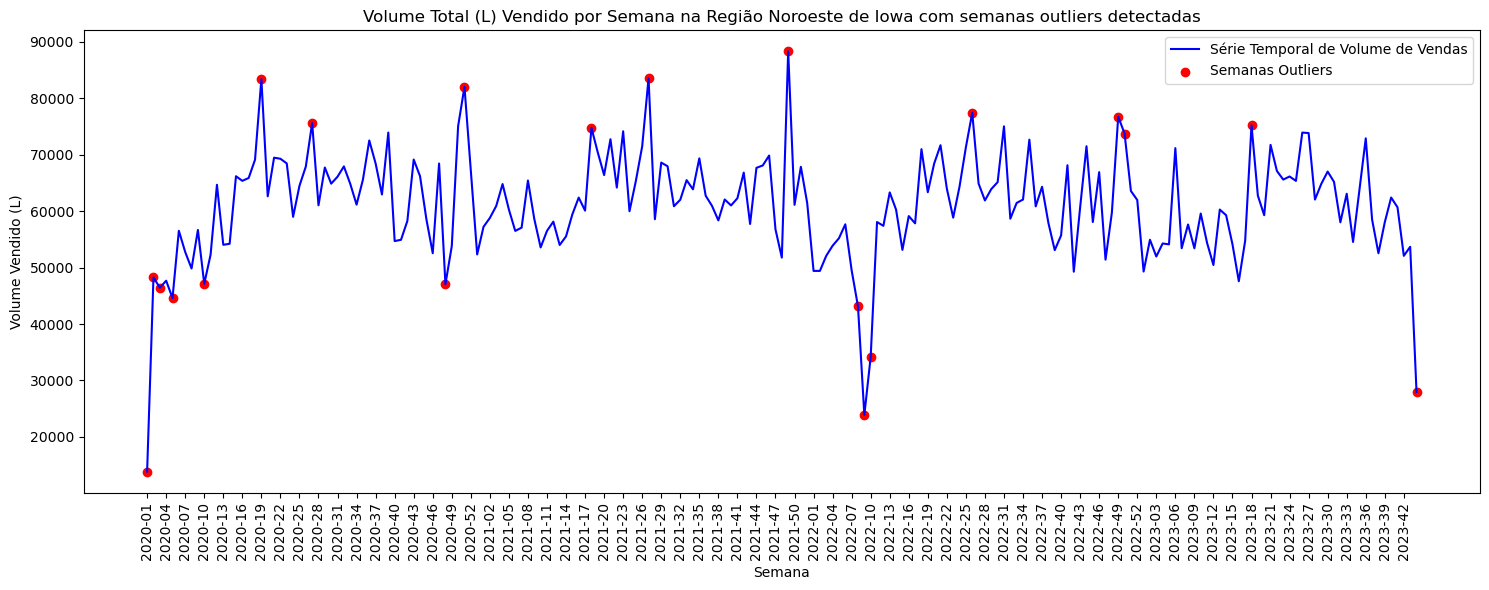

In [156]:
X = df_northwest[['Volume Sold (Liters)']]

isolation_forest = IsolationForest(contamination=0.1)

isolation_forest.fit(X)

outliers = isolation_forest.predict(X)

df_northwest.loc[:, 'outlier'] = outliers

df_northwest = df_northwest.sort_values('Year-Week', ascending=True)


plt.figure(figsize=(15, 6))
plt.plot(df_northwest['Year-Week'], df_northwest['Volume Sold (Liters)'], label='Série Temporal de Volume de Vendas', linestyle='-', color='b')
plt.scatter(df_northwest[df_northwest['outlier'] == -1]['Year-Week'], df_northwest[df_northwest['outlier'] == -1]['Volume Sold (Liters)'], color='red', label='Semanas Outliers')
plt.xlabel('Semana')
plt.ylabel('Volume Vendido (L)')
plt.title('Volume Total (L) Vendido por Semana na Região Noroeste de Iowa com semanas outliers detectadas')
plt.legend()

tick_labels = df_northwest['Year-Week'][::3]
plt.xticks(tick_labels, rotation=90)

plt.tight_layout()

plt.show()

Abaixo, então, apresentamos o perfil de faturamento (série temporal) após a remoção das semanas outliers.

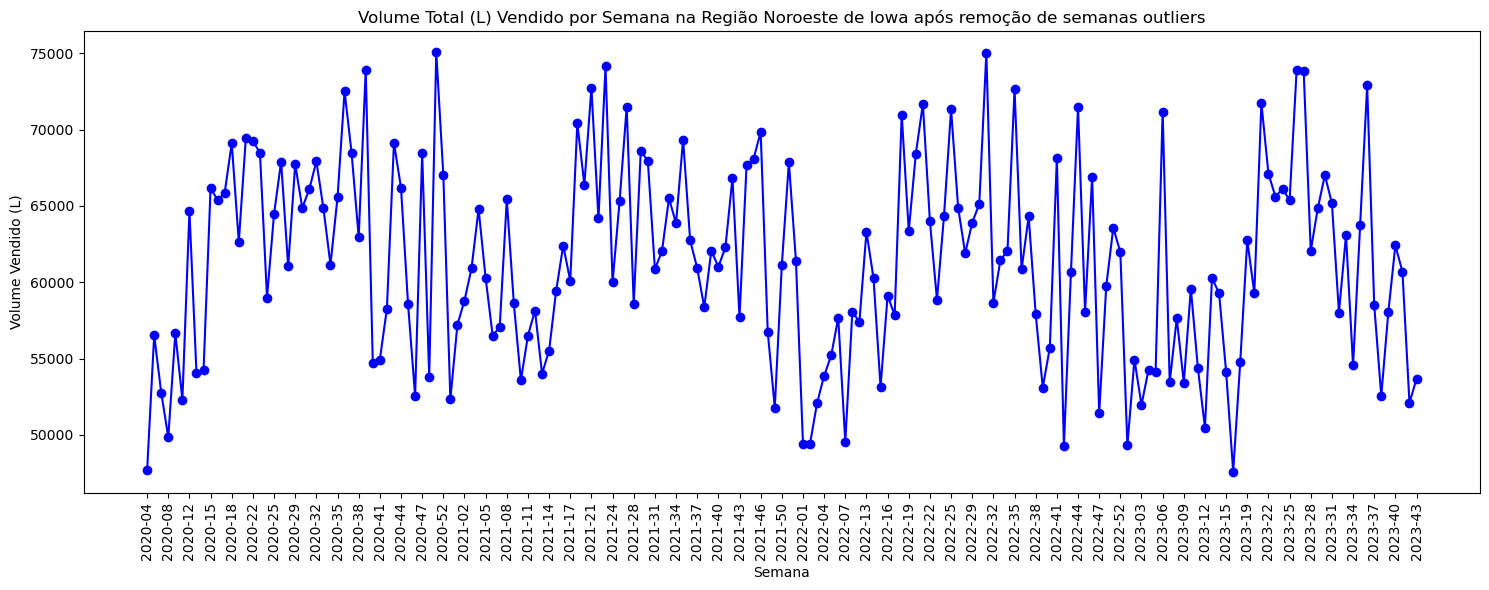

In [157]:
df_northwest = df_northwest.loc[df_northwest['outlier']!=-1]

plt.figure(figsize=(15, 6))
plt.plot(df_northwest['Year-Week'], df_northwest['Volume Sold (Liters)'], marker='o', linestyle='-', color='b')
plt.xlabel('Semana')
plt.ylabel('Volume Vendido (L)')
plt.title('Volume Total (L) Vendido por Semana na Região Noroeste de Iowa após remoção de semanas outliers')
plt.xticks(rotation=45) 
tick_labels = df_northwest['Year-Week'][::3]
plt.xticks(tick_labels, rotation=90)

plt.tight_layout()
plt.show()

Vamos também, abaixo, gerar um pequeno relatório que aponta algumas estatísticas da distribuição dos dados tratados. Estes dados servirão para, no TCC, apontar os resultados de uma análise exploratória dos dados em geral após o tratamento dos outliers e precedentes à separação em conjuntos de teste e de treinamento.

In [56]:
stats_report(df_northwest, cond="geral")

,Region,Soma,Media,Third_Q,First_Q,Mediana,Std,Max,Min,Skewness,Kurtosis,CV,IQR,Max - Min
0,Northwest,11139337.46,61543.300884,66189.58,56768.62,61423.11,6536.539524,75073.79,47586.58,0.024793,-0.756433,0.10621,9420.96,27487.21


Após o tratamento das semanas com Volumes outliers, vamos proceder com a separação dos dados nos conjuntos de treinamento e teste. Como estamos tratando séries temporais, os dados de treinamento precisam estar em um período anterior aos dados de teste, pois queremos sempre prever o futuro com base no passado. 

Assim, realizamos a separação dos conjuntos de forma que os dados de treinamento estão associados ao período de 2020, 2021, 2022 e até a 29º semana de 2023 enquanto os dados de teste compreendem o período da 30º semana de 2023 até a última semana de outubro de 2023 (44º semana no calendário).

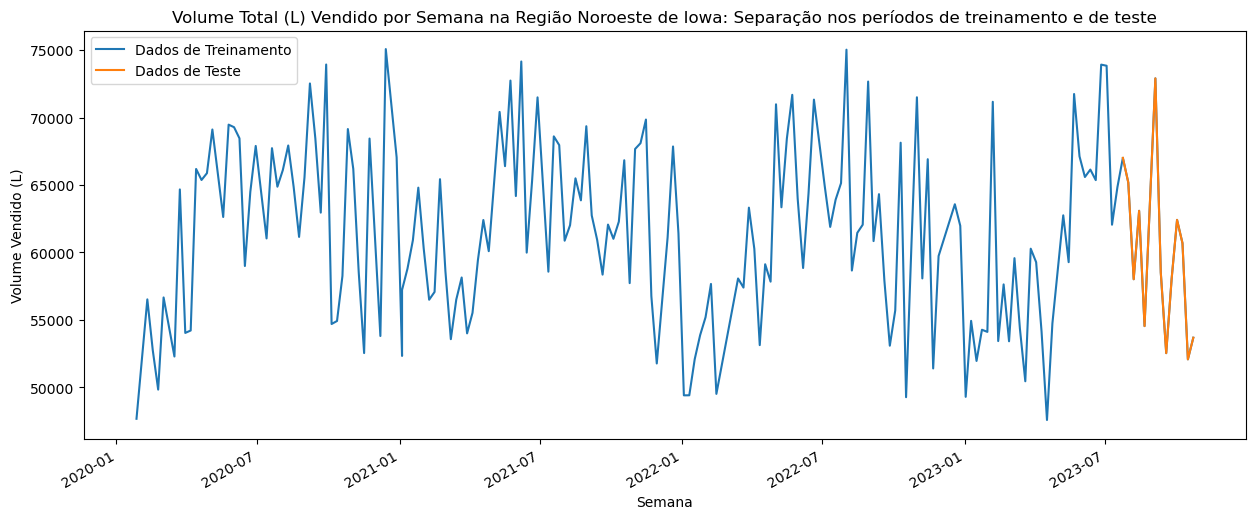

In [160]:
df_northwest_train = df_northwest.loc[(df_northwest['Year-Week'].str[:6] != "2023-3") | (df_northwest['Year-Week'].str[:6] != "2023-4")]
df_northwest_train_graph = df_northwest_train[["date_ref_week", "Volume Sold (Liters)"]].set_index('date_ref_week')
df_northwest_test = df_northwest.loc[(df_northwest['Year-Week'].str[:6] == "2023-3") | (df_northwest['Year-Week'].str[:6] == "2023-4")]
df_northwest_test_graph = df_northwest_test[["date_ref_week", "Volume Sold (Liters)"]].set_index('date_ref_week')

fig, ax = plt.subplots(figsize=(15, 6))
df_northwest_train_graph.plot(ax=ax, label='Treino', title='Volume Total (L) Vendido por Semana na Região Noroeste de Iowa: Separação nos períodos de treinamento e de teste')
df_northwest_test_graph.plot(ax=ax, label='Teste')
plt.ylabel('Volume Vendido (L)')
plt.xlabel('Semana')
ax.legend(['Dados de Treinamento', 'Dados de Teste'])
plt.show()

Vamos também, abaixo, gerar um pequeno relatório que aponta algumas estatísticas da distribuição dos dados em cada um dos conjuntos de dados de teste e de treinamento. Estes dados servirão para, no TCC, apontar os resultados de uma análise exploratória dos dados em cada um dos conjuntos de dados: treinamento e teste.

In [88]:
stats_report(df_northwest, cond="set")

,Region,Set,Soma,Media,Third_Q,First_Q,Mediana,Std,Max,Min,Skewness,Kurtosis,CV,IQR,Max - Min
0,Northwest,Test,1512413.06,63017.210833,66361.3675,58390.415,63428.82,6434.389025,73922.21,52081.99,0.020251,-0.752607,0.102105,7970.9525,21840.22
1,Northwest,Train,9656896.89,61508.897389,66192.3900,56667.620,61122.54,6503.043658,75073.79,49275.27,0.090171,-0.812685,0.105725,9524.7700,25798.52


### Mais etapas de engenharia de atributos: features de características temporais

Agora, procederemos para o desenvolvimento (criação) de mais variáveis para serem utilizadas nos modelos. Variáveis principalmente voltadas a valores antecedentes ao período vigente (lag features) como média móvel, média exponencialmente suavizada, desvio padrão móvel, valor da semana anterior e entre outros. 

In [161]:
# valor da semana anterior na séries temporal

df_northwest['Volume Sold (Liters) Lag 1'] = df_northwest['Volume Sold (Liters)'].shift(1)
df_northwest = df_northwest.dropna()

In [162]:
# média móvel exponencialmente suavizada considerando janelas móveis de 3 e 4 semanas

df_northwest['EMA Weekly_4'] = df_northwest['Volume Sold (Liters) Lag 1'].ewm(span=4, min_periods=1, adjust=True).mean()
df_northwest['EMA Weekly_3'] = df_northwest['Volume Sold (Liters) Lag 1'].ewm(span=3, min_periods=1, adjust=True).mean()

In [163]:
# média simples móvel considerando janelas móveis de 3 e 4 semanas

df_northwest['Rolling Mean_4'] = df_northwest['Volume Sold (Liters) Lag 1'].rolling(window=4, min_periods=1).mean()
df_northwest['Rolling Mean_3'] = df_northwest['Volume Sold (Liters) Lag 1'].rolling(window=3, min_periods=1).mean()

# desvio padrão amostral móvel considerando janelas móveis de 3 e 4 semanas

df_northwest['Rolling Std Dev_4'] = df_northwest['Volume Sold (Liters) Lag 1'].rolling(window=4, min_periods=1).std()
df_northwest['Rolling Std Dev_3'] = df_northwest['Volume Sold (Liters) Lag 1'].rolling(window=3, min_periods=1).std()

# valor máximo e mínimo de janelas móveis de 3 e 4 semanas

df_northwest['Rolling Min_4'] = df_northwest['Volume Sold (Liters) Lag 1'].rolling(window=4, min_periods=1).min()
df_northwest['Rolling Max_4'] = df_northwest['Volume Sold (Liters) Lag 1'].rolling(window=4, min_periods=1).max()
df_northwest['Rolling Min_3'] = df_northwest['Volume Sold (Liters) Lag 1'].rolling(window=3, min_periods=1).min()
df_northwest['Rolling Max_3'] = df_northwest['Volume Sold (Liters) Lag 1'].rolling(window=3, min_periods=1).max()

In [164]:
df_northwest = df_northwest.dropna()

Abaixo, criamos então mais features as quais olham para informações temporais de períodos futuros, como se nas próximas 1, 2 ou 3 semanas teremos alguma semana com começo de mês, de trimestre ou algum feriado.

In [165]:
start_date = date(2023, 10, 30)
end_date = date(2023, 11, 30)
date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

data = {
    'Region': ['dummy'] * len(date_list),
    'Date': date_list,
    'Volume Sold (Liters)': [0] * len(date_list)
}

df_dummy_weeks = pd.DataFrame(data)

df_dummy_weeks['Date'] = pd.to_datetime(df_dummy_weeks['Date'])
df_dummy_weeks['Year-Week'] = df_dummy_weeks['Date'].apply(lambda x: f"{x.isocalendar()[0]}-{x.isocalendar()[1]:02d}")
df_dummy_weeks['Week_of_year'] = df_dummy_weeks['Date'].dt.isocalendar().week
df_dummy_weeks['IsHoliday'] = is_iowa_holiday(df_dummy_weeks['Date'])
df_dummy_weeks['Is_quarter_end'] = df_dummy_weeks['Date'].apply(lambda x: 1 if x.is_quarter_end else 0)
df_dummy_weeks['Is_quarter_start'] = df_dummy_weeks['Date'].apply(lambda x: 1 if x.is_quarter_start else 0)
df_dummy_weeks['Is_month_start'] = df_dummy_weeks['Date'].apply(lambda x: 1 if x.is_month_start else 0)
df_dummy_weeks['Is_month_end'] = df_dummy_weeks['Date'].apply(lambda x: 1 if x.is_month_end else 0)

df_dummy_weeks = df_dummy_weeks.groupby(['Region', 'Year-Week']).agg({'Week_of_year': 'max',
                                                        'IsHoliday': 'max',
                                                        'Is_quarter_end': 'max',
                                                        'Is_quarter_start': 'max',
                                                        'Is_month_start': 'max',
                                                        'Is_month_end': 'max',
                                                        'Volume Sold (Liters)':'sum'}).reset_index()

df_dummy_weeks['date_ref_week'] = pd.to_datetime(df_dummy_weeks['Year-Week'] + '-1', format="%Y-%W-%w")

df_dummy_weeks['Month'] = df_dummy_weeks['date_ref_week'].dt.month
df_dummy_weeks['Week_of_month'] = (df_dummy_weeks['date_ref_week'].dt.day - 1) // 7 + 1
df_dummy_weeks['Quarter'] = df_dummy_weeks['date_ref_week'].dt.quarter
df_dummy_weeks['Days_in_month'] = df_dummy_weeks['date_ref_week'].dt.days_in_month

custom_column_names = df_northwest.columns[14:26]

df_dummy_weeks[custom_column_names] = 0

df_northwest = pd.concat([df_northwest, df_dummy_weeks], ignore_index=True)

df_northwest['next_1week_is_holiday'] = ((df_northwest['IsHoliday'].shift(-1) == 1)).replace({True: 1, False: 0})
df_northwest['next_2week_is_holiday'] = ((df_northwest['IsHoliday'].shift(-1) == 1) | (df_northwest['IsHoliday'].shift(-2) == 1)).replace({True: 1, False: 0})
df_northwest['next_3week_is_holiday'] = ((df_northwest['IsHoliday'].shift(-1) == 1) | (df_northwest['IsHoliday'].shift(-2) == 1) | (df_northwest['IsHoliday'].shift(-3) == 1)).replace({True: 1, False: 0})

df_northwest['next_1week_is_quarter_start'] = ((df_northwest['Is_quarter_start'].shift(-1) == 1)).replace({True: 1, False: 0})
df_northwest['next_2week_is_quarter_start'] = ((df_northwest['Is_quarter_start'].shift(-1) == 1) | (df_northwest['Is_quarter_start'].shift(-2) == 1)).replace({True: 1, False: 0})
df_northwest['next_3week_is_quarter_start'] = ((df_northwest['Is_quarter_start'].shift(-1) == 1) | (df_northwest['Is_quarter_start'].shift(-2) == 1) | (df_northwest['Is_quarter_start'].shift(-3) == 1)).replace({True: 1, False: 0})

df_northwest['next_1week_is_month_start'] = ((df_northwest['Is_month_start'].shift(-1) == 1)).replace({True: 1, False: 0})
df_northwest['next_2week_is_month_start'] = ((df_northwest['Is_month_start'].shift(-1) == 1) | (df_northwest['Is_month_start'].shift(-2) == 1)).replace({True: 1, False: 0})
df_northwest['next_3week_is_month_start'] = ((df_northwest['Is_month_start'].shift(-1) == 1) | (df_northwest['Is_month_start'].shift(-2) == 1) | (df_northwest['Is_month_start'].shift(-3) == 1)).replace({True: 1, False: 0})

df_northwest = df_northwest.loc[df_northwest['Region'] != "dummy"]

### Seleção das features

Agora, procederemos para a etapa de seleção das variáveis de input mais explicativas. A técnica utilizada é baseada em um artigo da literatura o qual utiliza uma variável completamente aleatória e o impacto desta e das demais variáveis: se uma variável original tem um impacto informacional no output menor que a variável completamente aleatória, podemos remover estas variáveis pois elas não possuem poder explicativo em relação ao output. De forma a medir o poder explicativo das variáveis, utilizaremos o feature_importance associado a um modelo de XGBoost com seus hiperparâmetros padrão.

In [ ]:
df_northwest = df_northwest.astype({'Week_of_year': 'int32'})

df_northwest['Random'] = np.random.uniform(0, len(df_northwest), len(df_northwest))

X = df_northwest.drop(['Volume Sold (Liters)', 'Region', 'Year-Week', 'date_ref_week', 'outlier'], axis=1)
Y = df_northwest[['Volume Sold (Liters)']]

rf = xgb.XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X, Y)

feature_importances = rf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(15, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

for i, v in enumerate(features_df['Importance']):
    plt.text(v + 0.005, i, f'{v:.2f}', ha='left', va='center')

plt.show()

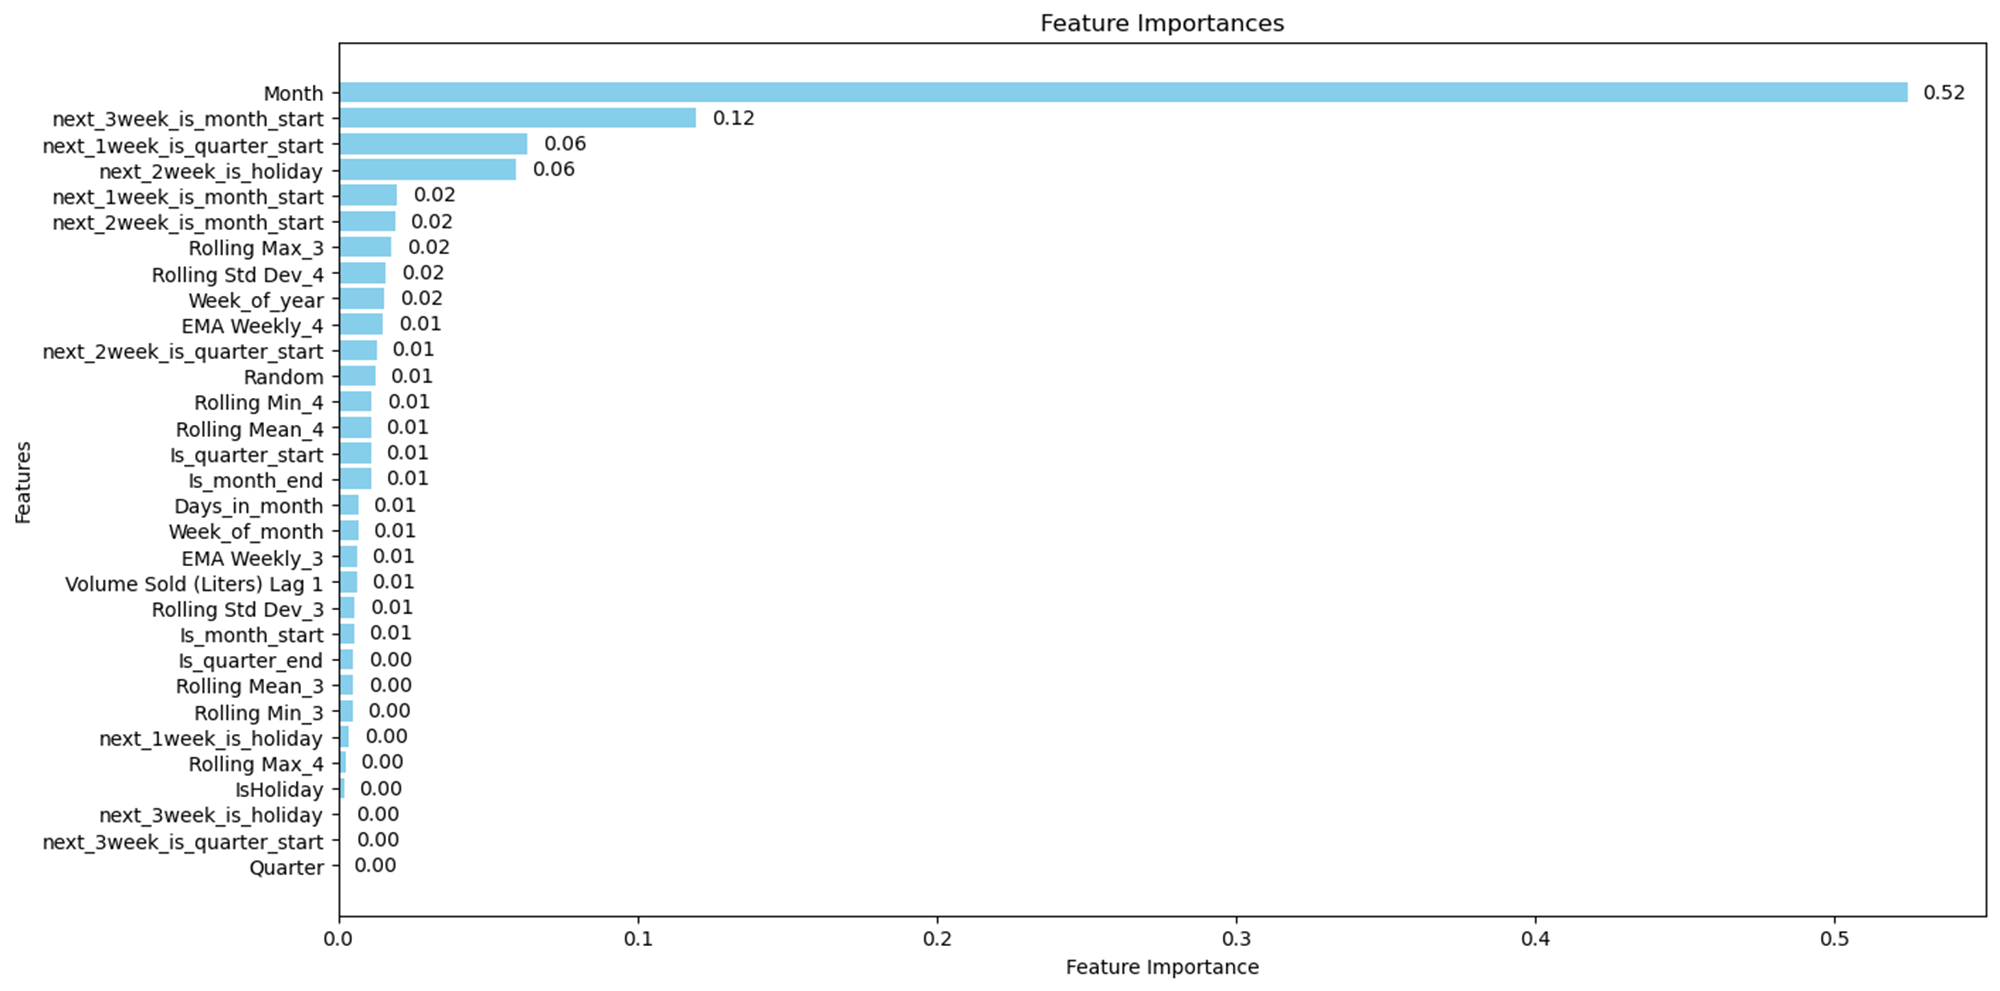

Podemos ver, então, que uma séries de variáveis possuem um feature_importance abaixo da variável aleatória (Random). Assim, manteremos para os modelos as variáveis com os feature_importances acima da Random.

In [61]:
threshold = features_df["Importance"].loc[features_df["Feature"]=="Random"].values[0]
selected_features = features_df.sort_values(by=["Importance"], ascending=False)["Feature"].loc[features_df["Importance"] > threshold].unique()
list(selected_features)

['Month',
 'next_3week_is_month_start',
 'next_1week_is_quarter_start',
 'next_2week_is_holiday',
 'next_1week_is_month_start',
 'next_2week_is_month_start',
 'Rolling Max_3',
 'Rolling Std Dev_4',
 'Week_of_year',
 'EMA Weekly_4',
 'next_2week_is_quarter_start']

In [166]:
selected_features = ['Month',
 'next_3week_is_month_start',
 'next_1week_is_quarter_start',
 'next_2week_is_holiday',
 'next_1week_is_month_start',
 'next_2week_is_month_start',
 'Rolling Max_3',
 'Rolling Std Dev_4',
 'Week_of_year',
 'EMA Weekly_4',
 'next_2week_is_quarter_start']

Separando o conjunto de dados original com todas as features criadas e selecionadas nos conjuntos de treinamento e de teste cujos períodos foram previamente ditos.

In [172]:
df_northwest_train = df_northwest.loc[(df_northwest['Year-Week'].str[:6] != "2023-3") | (df_northwest['Year-Week'].str[:6] != "2023-4")]
df_northwest_train.set_index("Year-Week", inplace=True)
df_northwest_test = df_northwest.loc[(df_northwest['Year-Week'].str[:6] == "2023-3") | (df_northwest['Year-Week'].str[:6] == "2023-4")]
df_northwest_test.set_index("Year-Week", inplace=True)

df_northwest_train_X = df_northwest_train[list(selected_features)]
df_northwest_train_y = df_northwest_train[['Volume Sold (Liters)']]

df_northwest_test_X = df_northwest_test[list(selected_features)]
df_northwest_test_y = df_northwest_test[['Volume Sold (Liters)']]

### Início dos treinamentos com os algoritmos XGBoost e LightGBM

Para cada algoritmo, encontraremos o melhor modelo realizando um ajuste fino dos hiperparâmetros com GridSearchCV com k = 3 (split feito com TimeSeriesSplit). Ainda, para cada algoritmo, testaremos os mesmos hiperparâmetros com opções idênticas de valores de forma a gerar resultados/modelos comparáveis. Os hiperparâmetros selecionados são hiperparâmetros comumente utilizados na busca por hiperparâmetros em modelos de ensemble na literatura.

As métricas de comparação de performance preditiva dos modelos escolhidas foram: MAPE, MAE e R^2.

## XGBoost:

Abaixo, podemos ver então que para o algoritmo XGBoost os valores encontrados no ajuste fino dos hiperparâmetros foram:

n_estimators = 200

max_depth = 9

learning_rate = 0.01

colsample_bytree = 0.5


Vamos treinar um modelo de XGBoost abaixo com estes hiperparâmetros e verificar suas métricas de desempenho nos dados de treinamento.

In [63]:
param_grid = {
    'n_estimators': [25, 50, 100, 200, 300, 600, 800, 1000],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.8, 1]
}

tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor(random_state=42)

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)

grid_search.fit(df_northwest_train_X, df_northwest_train_y.values.ravel())

print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}


### Dados de Treinamento

In [64]:
best_model = xgb.XGBRegressor(random_state=42, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200).fit(df_northwest_train_X, df_northwest_train_y.values.ravel())

df_northwest_train_y['volume_predicted'] = best_model.predict(df_northwest_train_X)

r2 = r2_score(df_northwest_train_y['Volume Sold (Liters)'], df_northwest_train_y['volume_predicted'])
print("R-squared:", r2)

mape = mean_absolute_percentage_error(df_northwest_train_y['Volume Sold (Liters)'], df_northwest_train_y['volume_predicted'])
print("Mean Absolute Percentage Error (MAPE):", mape)

mae = mean_absolute_error(df_northwest_train_y['Volume Sold (Liters)'], df_northwest_train_y['volume_predicted'])
print("Mean Absolute Error (MAE):", mae)

R-squared: 0.902765748947906
Mean Absolute Percentage Error (MAPE): 0.025517159627940256
Mean Absolute Error (MAE): 1543.0522101955298


C:\Users\artur\AppData\Local\Temp\ipykernel_25672\718625745.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_northwest_train_y['volume_predicted'] = best_model.predict(df_northwest_train_X)


Resultados obtidos para o modelo XGBoost nos dados de Treinamento:

R^2: 0.9028

MAPE: 2.55%

MAE: 1543.05 (L)

In [65]:
# Salvando o modelo em formato pickle

with open('artifacts\model_xgboost.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

Abaixo, plotamos os dados reais de treinamento e suas respectivas previsões conforme modelo treinado anteriormente após o ajuste fino.

In [178]:
def load_model_xgboost():
    with open('artifacts\model_xgboost.pkl', 'rb') as model:
        xgboost_model = pickle.load(model)
    return xgboost_model

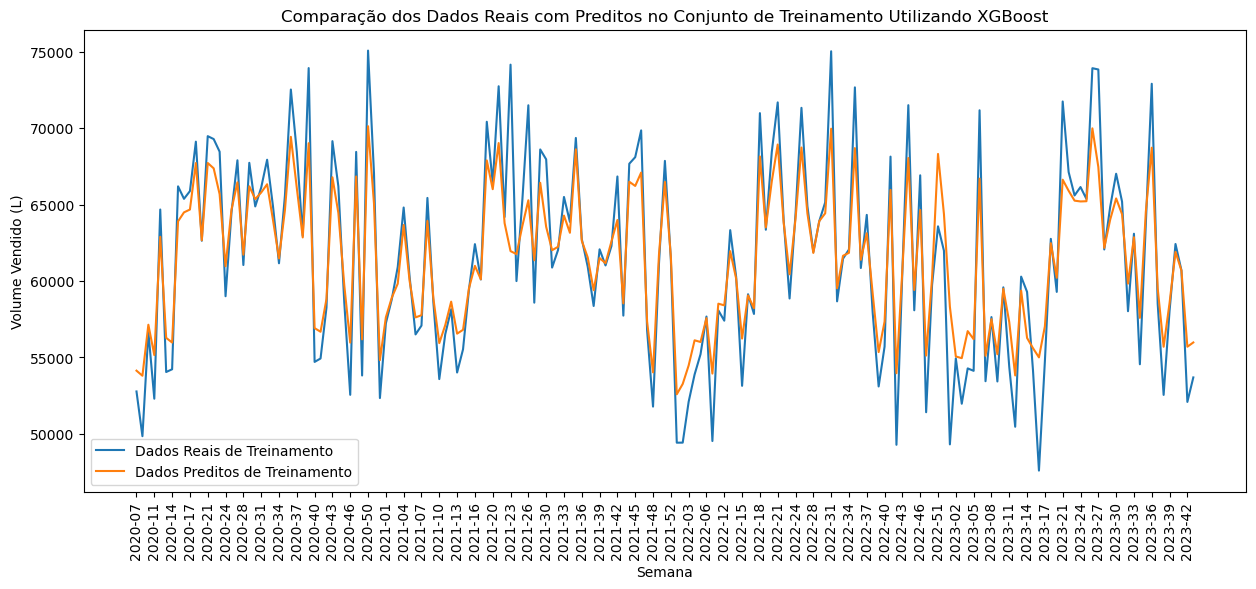

In [175]:
df_northwest_train_y['volume_predicted'] = load_model_xgboost().predict(df_northwest_train_X)

fig, ax = plt.subplots(figsize=(15, 6))
df_northwest_train_y['Volume Sold (Liters)'].plot(ax=ax, label='Training', title='Comparação dos Dados Reais com Preditos no Conjunto de Treinamento Utilizando XGBoost')
df_northwest_train_y['volume_predicted'].plot(ax=ax, label='Test')
ax.legend(['Dados Reais de Treinamento', 'Dados Preditos de Treinamento'])
plt.ylabel('Volume Vendido (L)')
plt.xlabel('Semana')

tick_positions = np.arange(0, len(df_northwest_train_y), step=3)
ax.set_xticks(tick_positions)
ax.set_xticklabels(df_northwest_train_y.index[tick_positions], rotation=90) 

plt.show()

### Dados de Teste

In [67]:
df_northwest_test_y['volume_predicted'] = load_model_xgboost().predict(df_northwest_test_X)

r2 = r2_score(df_northwest_test_y['Volume Sold (Liters)'], df_northwest_test_y['volume_predicted'])
print("R-squared:", r2)

mape = mean_absolute_percentage_error(df_northwest_test_y['Volume Sold (Liters)'], df_northwest_test_y['volume_predicted'])
print("Mean Absolute Percentage Error (MAPE):", mape)

mae = mean_absolute_error(df_northwest_test_y['Volume Sold (Liters)'], df_northwest_test_y['volume_predicted'])
print("Mean Absolute Error (MAE):", mae)

R-squared: 0.8646001870766395
Mean Absolute Percentage Error (MAPE): 0.028776819645228817
Mean Absolute Error (MAE): 1682.1042745535701


C:\Users\artur\AppData\Local\Temp\ipykernel_25672\1084415119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_northwest_test_y['volume_predicted'] = best_model.predict(df_northwest_test_X)


Resultados obtidos para o modelo XGBoost nos dados de Teste:

R^2: 0.8646

MAPE: 2.88%

MAE: 1682.10 (L)

Abaixo, plotamos os dados reais de teste e suas respectivas previsões conforme modelo treinado anteriormente após o ajuste fino.

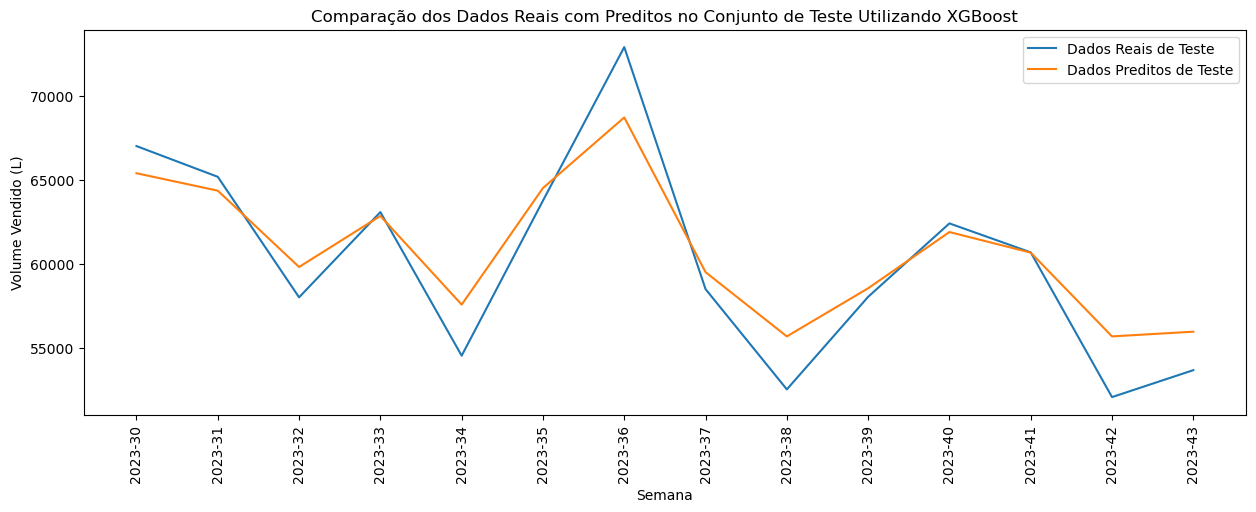

In [201]:
df_northwest_test_y['volume_predicted'] = load_model_xgboost().predict(df_northwest_test_X)

fig, ax = plt.subplots(figsize=(15, 5))
df_northwest_test_y['Volume Sold (Liters)'].plot(ax=ax, label='Training', title='Comparação dos Dados Reais com Preditos no Conjunto de Teste Utilizando XGBoost')
df_northwest_test_y['volume_predicted'].plot(ax=ax, label='Test')
ax.legend(['Dados Reais de Teste', 'Dados Preditos de Teste'])
plt.ylabel('Volume Vendido (L)')
plt.xlabel('Semana')

tick_positions = np.arange(0, len(df_northwest_test_y), step=1)
ax.set_xticks(tick_positions)
ax.set_xticklabels(df_northwest_test_y.index[tick_positions], rotation=90)
plt.show()

## LightGBM:

Abaixo, podemos ver então que para o algoritmo LightGBM os valores encontrados no ajuste fino dos hiperparâmetros foram:

n_estimators = 50

max_depth = 6

learning_rate = 0.3

colsample_bytree = 0.8


Vamos treinar um modelo de LightGBM abaixo com estes hiperparâmetros e verificar suas métricas de desempenho nos dados de treinamento.

In [42]:
df_northwest_train = df_northwest.loc[(df_northwest['Year-Week'].str[:6] != "2023-3") | (df_northwest['Year-Week'].str[:6] != "2023-4")]
df_northwest_train.set_index("Year-Week", inplace=True)
df_northwest_test = df_northwest.loc[(df_northwest['Year-Week'].str[:6] == "2023-3") | (df_northwest['Year-Week'].str[:6] == "2023-4")]
df_northwest_test.set_index("Year-Week", inplace=True)

df_northwest_train_X = df_northwest_train[list(selected_features)]
df_northwest_train_y = df_northwest_train[['Volume Sold (Liters)']]

df_northwest_test_X = df_northwest_test[list(selected_features)]
df_northwest_test_y = df_northwest_test[['Volume Sold (Liters)']]


param_grid = {
    'n_estimators': [25, 50, 100, 200, 300, 600, 800, 1000],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.8, 1]
}

tscv = TimeSeriesSplit(n_splits=3)

model = lightgbm.LGBMRegressor(verbose=-1, random_state=42)

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)

grid_search.fit(df_northwest_train_X, df_northwest_train_y.values.ravel())

print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 50}


### Dados de Treinamento

In [40]:
best_model = lightgbm.LGBMRegressor(verbose=-1, random_state=42, colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=50).fit(df_northwest_train_X, df_northwest_train_y.values.ravel())

df_northwest_train_y['volume_predicted'] = best_model.predict(df_northwest_train_X)

r2 = r2_score(df_northwest_train_y['Volume Sold (Liters)'], df_northwest_train_y['volume_predicted'])
print("R-squared:", r2)

mape = mean_absolute_percentage_error(df_northwest_train_y['Volume Sold (Liters)'], df_northwest_train_y['volume_predicted'])
print("Mean Absolute Percentage Error (MAPE):", mape)

mae = mean_absolute_error(df_northwest_train_y['Volume Sold (Liters)'], df_northwest_train_y['volume_predicted'])
print("Mean Absolute Error (MAE):", mae)

R-squared: 0.768491135549793
Mean Absolute Percentage Error (MAPE): 0.038981858072719776
Mean Absolute Error (MAE): 2369.048218272938


C:\Users\artur\AppData\Local\Temp\ipykernel_25672\1549249525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_northwest_train_y['volume_predicted'] = best_model.predict(df_northwest_train_X)


Resultados obtidos para o modelo LightGBM nos dados de Treinamento:

R^2: 0.7685

MAPE: 3.90%

MAE: 2369.05 (L)

In [41]:
# Salvando o modelo em formato pickle

with open('artifacts\model_lightgbm.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

Abaixo, plotamos os dados reais de treinamento e suas respectivas previsões conforme modelo treinado anteriormente após o ajuste fino.

In [188]:
def load_model_lightgbm():
    with open('artifacts\model_lightgbm.pkl', 'rb') as model:
        lightgbm_model = pickle.load(model)
    return lightgbm_model

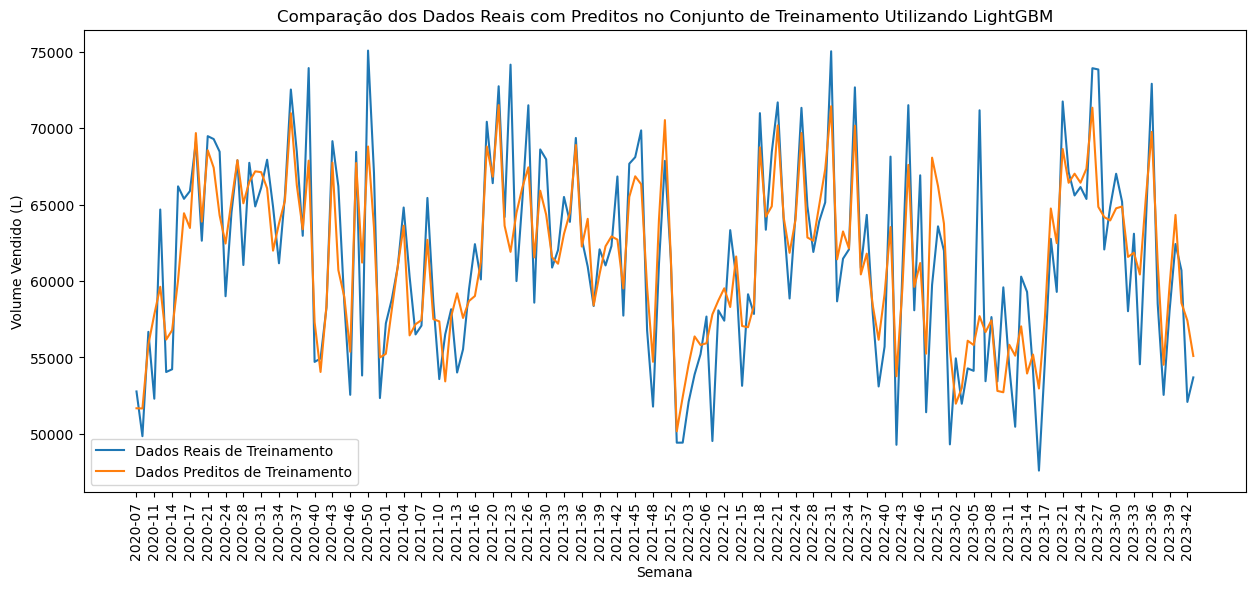

In [192]:
df_northwest_train_y['volume_predicted'] = load_model_lightgbm().predict(df_northwest_train_X)

fig, ax = plt.subplots(figsize=(15, 6))
df_northwest_train_y['Volume Sold (Liters)'].plot(ax=ax, label='Training', title='Comparação dos Dados Reais com Preditos no Conjunto de Treinamento Utilizando LightGBM')
df_northwest_train_y['volume_predicted'].plot(ax=ax, label='Test')
ax.legend(['Dados Reais de Treinamento', 'Dados Preditos de Treinamento'])
plt.ylabel('Volume Vendido (L)')
plt.xlabel('Semana')

tick_positions = np.arange(0, len(df_northwest_train_y), step=3)
ax.set_xticks(tick_positions)
ax.set_xticklabels(df_northwest_train_y.index[tick_positions], rotation=90) 

plt.show()

### Dados de Teste

In [33]:
df_northwest_test_y['volume_predicted'] = load_model_lightgbm().predict(df_northwest_test_X)

r2 = r2_score(df_northwest_test_y['Volume Sold (Liters)'], df_northwest_test_y['volume_predicted'])
print("R-squared:", r2)

mape = mean_absolute_percentage_error(df_northwest_test_y['Volume Sold (Liters)'], df_northwest_test_y['volume_predicted'])
print("Mean Absolute Percentage Error (MAPE):", mape)

mae = mean_absolute_error(df_northwest_test_y['Volume Sold (Liters)'], df_northwest_test_y['volume_predicted'])
print("Mean Absolute Error (MAE):", mae)

R-squared: 0.747235004354616
Mean Absolute Percentage Error (MAPE): 0.042999672135385976
Mean Absolute Error (MAE): 2507.728622758565


C:\Users\artur\AppData\Local\Temp\ipykernel_25672\1084415119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_northwest_test_y['volume_predicted'] = best_model.predict(df_northwest_test_X)


Resultados obtidos para o modelo LightGBM nos dados de Teste:

R^2: 0.7423

MAPE: 4.30%

MAE: 2507.73 (L)

Abaixo, plotamos os dados reais de teste e suas respectivas previsões conforme modelo treinado anteriormente após o ajuste fino.

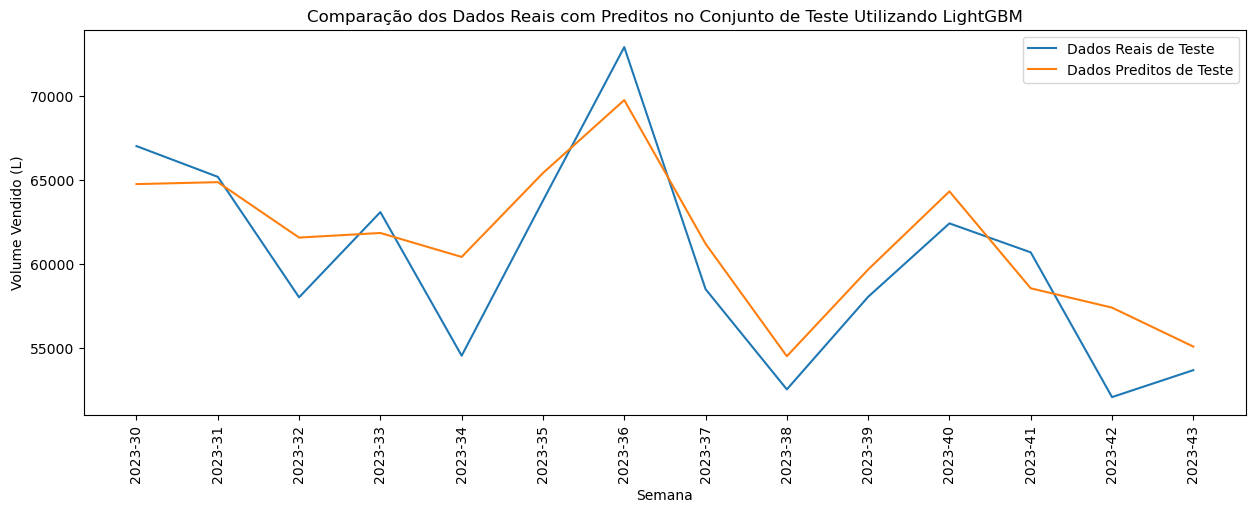

In [193]:
df_northwest_test_y['volume_predicted'] = load_model_lightgbm().predict(df_northwest_test_X)

fig, ax = plt.subplots(figsize=(15, 5))
df_northwest_test_y['Volume Sold (Liters)'].plot(ax=ax, label='Training', title='Comparação dos Dados Reais com Preditos no Conjunto de Teste Utilizando LightGBM')
df_northwest_test_y['volume_predicted'].plot(ax=ax, label='Test')
ax.legend(['Dados Reais de Teste', 'Dados Preditos de Teste'])
plt.ylabel('Volume Vendido (L)')
plt.xlabel('Semana')

tick_positions = np.arange(0, len(df_northwest_test_y), step=1)
ax.set_xticks(tick_positions)
ax.set_xticklabels(df_northwest_test_y.index[tick_positions], rotation=90)
plt.show()